In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from skimage import io, color

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def rgb2hsv(input, epsilon=1e-10):
    assert(input.shape[0] == 3)

    r, g, b = input[0], input[1], input[2]
    max_rgb, argmax_rgb = input.max(0)
    min_rgb, argmin_rgb = input.min(0)

    max_min = max_rgb - min_rgb + epsilon 

    h1 = 60.0 * (g - r) / max_min + 60.0
    h2 = 60.0 * (b - g) / max_min + 180.0
    h3 = 60.0 * (r - b) / max_min + 300.0

    h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
    s = max_min / (max_rgb + epsilon)
    v = max_rgb

    return torch.stack((h, s, v), dim=0)

def hsv2rgb(input):
    assert(input.shape[0] == 3)

    h, s, v = input[0], input[1], input[2]
    h_ = (h - torch.floor(h / 360) * 360) / 60
    c = s * v
    x = c * (1 - torch.abs(torch.fmod(h_, 2) - 1))

    zero = torch.zeros_like(c)
    y = torch.stack((
        torch.stack((c, x, zero), dim=0),
        torch.stack((x, c, zero), dim=0),
        torch.stack((zero, c, x), dim=0),
        torch.stack((zero, x, c), dim=0),
        torch.stack((x, zero, c), dim=0),
        torch.stack((c, zero, x), dim=0),
    ), dim=0)
    index = torch.repeat_interleave(torch.floor(h_).unsqueeze(0), 3, dim=0).unsqueeze(0).to(torch.long)
    rgb = (y.gather(dim=0, index=index) + (v - c)).squeeze(0)
    return rgb

def preprocess(img):
    img_original = img.numpy().transpose((1, 2, 0))
    img_lab = color.rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_l = img_lab[:, :, 0]
    img_l = torch.from_numpy(img_l).float().unsqueeze(0)
    img_gray = color.rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_ab, img_l

def combinelab2rgb(l, a, b):
    img_lab = torch.stack([l, a, b])
    img_lab = img_lab * 255 - 128
    img_rgb = color.lab2rgb(img_lab.detach().numpy().transpose((1, 2, 0)))
    img_rgb = torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()
    return img_rgb

d:\anaconda3\envs\cse455\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [216]:
class ExtractorInceptionV3(nn.Module):
    def __init__(self):
        super(ExtractorInceptionV3, self).__init__()
        model = models.inception_v3()
        model.Conv2d_1a_3x3.conv.weight = nn.Parameter(model.Conv2d_1a_3x3.conv.weight.sum(dim=1).unsqueeze(1))
        self.layers = nn.Sequential(
            *list(model.children())[0:14],
            nn.Upsample(scale_factor=2),
            nn.Conv2d(768, 384, kernel_size=3, padding=1, stride=1)
        )


    def forward(self, x):
        x = self.layers(x)
        return x

class ExtractorResnet152(nn.Module):
    def __init__(self):
        super(ExtractorResnet152, self).__init__()
        model = models.resnet152()
        model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1).unsqueeze(1))
        self.layers = nn.Sequential(
            *list(model.children())[0:6]
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class ColorNetResnet18(nn.Module):

    def __init__(self, mid_input_size=0):
        super(ColorNetResnet18, self).__init__()
        self.mid_input_size = mid_input_size
        resnet = models.resnet18()
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        self.decoder = nn.Sequential(
            nn.Conv2d(mid_input_size + 128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Softmax(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.mid_input_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

class ColorNetResnet50(nn.Module):

    def __init__(self, mid_input_size=0):
        super(ColorNetResnet50, self).__init__()
        resnet = models.resnet50()
        self.mid_input_size = mid_input_size
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        self.decoder = nn.Sequential(
            nn.Conv2d(mid_input_size + 512, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Softmax(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.mid_input_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

In [227]:
extractor = ExtractorResnet152()
model = ColorNetResnet18(mid_input_size=extractor(torch.zeros((1, 1, 256, 256))).shape[1])

In [8]:
def get_datasets(dataset_path):
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ]))

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [69]:
places365_train, places365_test = get_datasets("places365_standard/")

In [10]:
wikiart_train, wikiart_test = get_datasets("wikiart/")

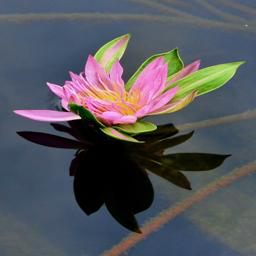

In [223]:
T.ToPILImage()(places365_train[12][0])

In [225]:
gray_scale = T.Grayscale()
checkpoint_path = 'models/auto_color.pth'

def train(model, extractor, train_dataset, plot_name, num_batches=10, batch_size=16, epochs=100, lr=0.1, decay=1e-10):
  model.to(device)
  losses = []
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
  min_loss = 10000
  with tqdm(range(epochs)) as eps:
    for e in eps:
      total_loss = 0
      for idx in range(num_batches):
        try:
          # sample an image batch
          batch_idx = [e]
          # batch_idx = random.choices(np.arange(len(train_dataset)), k=1)
          train_images = [preprocess(train_dataset[n][0]) for n in batch_idx]
          gray_inputs = torch.stack([im[0] for im in train_images]).to(device)
          ab_inputs = torch.stack([im[1] for im in train_images]).to(device)
        except:
          continue

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        ab_outputs = model(gray_inputs, extractor(gray_inputs)).to(device)
        loss = criterion(ab_outputs, ab_inputs)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction
        total_loss += loss.item().real
        eps.set_postfix(progress=str(idx/num_batches * 100) +"%")

      mean_loss = total_loss / num_batches
      eps.set_postfix(loss=mean_loss)
      # print statistics
      if (mean_loss < min_loss):
        min_loss = mean_loss
        torch.save(model.state_dict(), checkpoint_path)
      if (e % 20 == 0 and e != 0):
        losses.append(mean_loss)
        plt.figure()
        plt.plot(losses)
        plt.yscale('log')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.savefig(plot_name)
        plt.close('all')

In [228]:
for e in range(1000):
    train(model, extractor, places365_train, num_batches=1, epochs=1, lr=0.01, plot_name=f"losses_epoch={e}")

  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [110]:
len(places365_train)

1045129

In [189]:
model = ColorNetResnet50()

In [234]:
batch_idx = random.choices(np.arange(1), k=1)
batch_idx = [12]
train_images = [preprocess(places365_train[n][0]) for n in batch_idx]
gray_inputs = torch.stack([im[0] for im in train_images]).to(device)
ab_inputs = torch.stack([im[1] for im in train_images]).to(device)
l_inputs = torch.stack([im[2] for im in train_images]).to(device)
ab_outputs = model(gray_inputs, extractor(gray_inputs))
rgb_inputs = torch.stack([places365_train[n][0] for n in batch_idx])
rgb_outputs = torch.stack([combinelab2rgb(l_inputs[i][0], ab_outputs[i][0], ab_outputs[i][1]) for i in range(len(ab_outputs))])

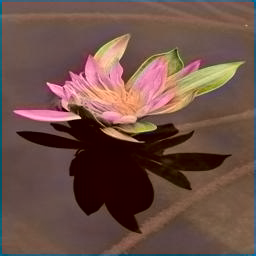

In [235]:
T.ToPILImage()(rgb_outputs[0])

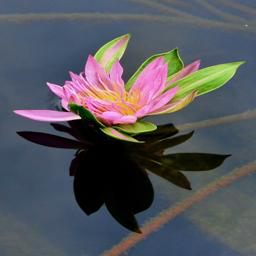

In [231]:
T.ToPILImage()(rgb_inputs[0])